In [1]:
#!/usr/bin/env python

# Copyright (c) 2018-2021, Vijay Kandiah, Junrui Pan, Mahmoud Khairy, Scott Peverelle, Timothy Rogers, Tor M. Aamodt, Nikos Hardavellas
# Northwestern University, Purdue University, The University of British Columbia
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer;
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution;
# 3. Neither the names of Northwestern University, Purdue University,
#    The University of British Columbia nor the names of their contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

import json
import csv
import pandas as pd
import numpy
import os 
import collections 
import glob
import sys
from os.path import dirname, basename, isfile, join
import shutil

In [2]:
rootdir = os.getcwd();
results_dir = rootdir + '/accelwattch_power_reports'
os.listdir(results_dir)

['power_ubench_datatype_sass_sim_second',
 'power_ubench',
 '1530_one_op_traces',
 'TeslaV100_BadLDC-Accelwattch_SASS_SIM',
 'TeslaV100_Incomplete_BadLCDInsts_volta_sass_hw',
 'verify_classify_one_op_traces',
 'QV100_volta_sass_hw',
 'one_op_traces',
 'power_ubench_datatype_sass_sim',
 'ubench_1iter',
 'ubench_datatype_volta_sass_sim',
 'volta_hw_sass_GPU_Microbench',
 'TeslaV100_tuner_only_volta_sass_hw',
 'ubench_2iter']

In [3]:
configs = ["1530_one_op_traces",
           "one_op_traces",
           "validate_one_op_traces",
           "ubench_2iter",
           "ubench_1iter","ubench_datatype_volta_sass_sim","power_ubench_datatype_sass_sim","TeslaV100_BadLDC-Accelwattch_SASS_SIM","power_ubench","TeslaV100_Incomplete_BadLCDInsts_volta_sass_hw","volta_hw_sass_GPU_Microbench"]
config = configs[1] #Target one of the configs
print(f"Processing logs from accelwattch_power_reports/{config}")

Processing logs from accelwattch_power_reports/one_op_traces


In [4]:
power_counters = ['IBP,', 'ICP,', 'DCP,', 'TCP,', 'CCP,', 'SHRDP,', 'RFP,', 
                    'INTP,', 'FPUP,', 'DPUP,', 'INT_MUL24P,', 'INT_MUL32P,', 'INT_MULP,','INT_DIVP,', 'FP_MULP,',
                    'FP_DIVP,', 'FP_SQRTP,', 'FP_LGP,', 'FP_SINP,', 'FP_EXP,','DP_MULP,', 'DP_DIVP,', 'TENSORP,', 'TEXP,',                                  
                    'SCHEDP,', 'L2CP,', 'MCP,', 'NOCP,', 'DRAMP,','PIPEP,', 'IDLE_COREP,', 'CONSTP','STATICP','kernel_avg_power','kernel_max_power']
rootdir = os.getcwd();
results_dir = rootdir + '/accelwattch_results'

print("Collecting AccelWattch power results for " + config)
reportspath = rootdir + '/accelwattch_power_reports/' + config
avg_power_dict = {}
max_power_dict = {}
print("Number of power counters",len(power_counters))

Number of power counters 35


In [5]:
benchmarks = []
for dirname in os.listdir(reportspath):
    benchmarks.append(dirname[:-4])
bad_benchmarks_list = [
    "cutlass_perf_test_k1",
    "cutlass_perf_test_k2",
    "cutlass_perf_test_k3",
    "parboil-mri-q",
    "dct8x8",
    "binomialOptions",
    "quasirandomGenerator",
    "kmeans-rodinia-3.1"
]
if "Bad" in config:
    for bad_benchmark in bad_benchmarks_list:
        if bad_benchmark in benchmarks:
            benchmarks.remove(bad_benchmark)
benchmarks



['EXIT_SM7_QV100',
 'LDG_E_SYS_SM7_QV100',
 'DEPBAR_LE_Tesla_V100',
 'MUFU.EX2_SM7_QV100',
 'BSSY_SM7_QV100',
 'TLD_Tesla_V100',
 'NOP_SM7_QV100',
 'TLD_SM7_QV100',
 'BAR_SYNC_SM7_QV100',
 'BSSY_Tesla_V100',
 'BAR_SYNC_Tesla_V100',
 'DEPBAR_LE_SM7_QV100',
 'BSYNC_SM7_QV100',
 'S2R_SM7_QV100',
 'BRA_SM7_QV100',
 'STS_Tesla_V100',
 'EXIT_Tesla_V100',
 'LDC_SM7_QV100',
 'RET_REL_NODEC_Tesla_V100',
 'MUFU_RCP_Tesla_V100',
 'CALL_REL_NOINC_SM7_QV100',
 'BMOV_32_CLEAR_Tesla_V100',
 'NOP_Tesla_V100',
 'STG_E_SYS_Tesla_V100',
 'RET_REL_NODEC_SM7_QV100',
 'MUFU_RCP64H_Tesla_V100',
 'BREAK_SM7_QV100',
 'LDS_U_SM7_QV100',
 'LDC_Tesla_V100',
 'CALL_REL_NOINC_Tesla_V100',
 'STG_E_SYS_SM7_QV100',
 'STS_SM7_QV100',
 'LDG_E_SYS_Tesla_V100',
 'BRA_Tesla_V100',
 'MUFU.EX2_Tesla_V100',
 'BREAK_Tesla_V100',
 'MUFU_RCP64H_SM7_QV100',
 'LDS_U_Tesla_V100',
 'BSYNC_Tesla_V100',
 'MUFU_RCP_SM7_QV100',
 'S2R_Tesla_V100',
 'BMOV_32_CLEAR_SM7_QV100']

In [6]:
kernel_name_map = {}
for benchmark in benchmarks:#[benchmarks[1]]:
    with open((reportspath + '/' + benchmark + '.log'), 'r') as f:
        x = f.readlines()
    kernels_encountered = 1
    unique_kernel_counts = {}
    kernelnameheader = 'kernel_name='
    baselines = collections.OrderedDict()
    max_baselines = {}
    #Clean up spaces within the file
    for each in range(len(x)):
        x[each] = x[each].replace(" ", "")
    
    #Go through the file and stop once we find the start of a kernel
    for each in range(len(x)):
        #If we have the kernel header line
        if (x[each].find(kernelnameheader) != -1):
            _,kernelname=x[each].strip().split('=')
            if kernelname not in unique_kernel_counts:
                #kernelname=kernelname.strip()
                unique_kernel_counts[kernelname] = 1
                benchmark_idx = (benchmark + '_k' + str(kernels_encountered))
                kernel_name_map[kernelname] = benchmark_idx
                avg_power_dict[benchmark_idx] ={}
                max_power_dict[benchmark_idx] ={}
                kernels_encountered += 1
                
                baselines[benchmark_idx] = collections.OrderedDict()
                max_baselines[benchmark_idx] = collections.OrderedDict()
                for counter in power_counters:
                    baselines[benchmark_idx][counter] = 0
                    max_baselines[benchmark_idx][counter] = 0
            else:
                unique_kernel_counts[kernelname] += 1 
            # print(type(x))
##############################
#Get the value kernel_avg_power
##############################
            key,value = x[each+4].split('=')
            # print(key)
            value = value.rstrip('\n')
            #Set the baseline equal to this value
            baselines[kernel_name_map[kernelname]][(key)] += float(value)
            #For the other avg_power_stats            
            for stat in range(5,38):
                key,value = x[each+stat].split('=')
                # print(key,stat-4)
                value = value.rstrip('\n')
                baselines[kernel_name_map[kernelname]][(key[8:])] += float(value)
##############################
#Get the max kernel values
##############################
            key,value = x[each+129].split('=')
#             print(key)
            value = value.rstrip('\n')
            #Set the baseline equal to this value
            max_baselines[kernel_name_map[kernelname]][(key)] += float(value)
            #For the other avg_power_stats            
            for stat in range(130,163):
                key,value = x[each+stat].split('=')
                # print(key,stat-4)
                value = value.rstrip('\n')
                max_baselines[kernel_name_map[kernelname]][(key[8:])] += float(value)

    # print(benchmark,baselines)
    #Reverse index to kernelname mapping
    bench_idx_to_kernelname_dict = {v:k for k,v in kernel_name_map.items()}
    if len(kernel_name_map) != len(bench_idx_to_kernelname_dict):
        print("Error in mapping kernels to given benchmark_idx")
        continue
    for benchmark_idx in baselines:
        kernelname = bench_idx_to_kernelname_dict[benchmark_idx]
        # Average the power values based on now many times this kernel appears
        #   This is done because we sum the powers of each kernel call
        #   This normalizes the power across different kernel calls that have the same name
        for each in power_counters:
            #power_dict[benchmark_idx][each] = float(baseline[each])
            avg_power_dict[benchmark_idx][each] = float(baselines[benchmark_idx][each]) / float(unique_kernel_counts[kernelname])
        avg_power_dict[benchmark_idx]['DRAMP,'] = avg_power_dict[benchmark_idx]['DRAMP,'] + avg_power_dict[benchmark_idx]['MCP,']
        avg_power_dict[benchmark_idx]['L2CP,'] = avg_power_dict[benchmark_idx]['L2CP,'] + avg_power_dict[benchmark_idx]['NOCP,']

        for each in power_counters:
            max_power_dict[benchmark_idx][each] = float(max_baselines[benchmark_idx][each]) / float(unique_kernel_counts[kernelname])
        max_power_dict[benchmark_idx]['DRAMP,'] = max_power_dict[benchmark_idx]['DRAMP,'] + max_power_dict[benchmark_idx]['MCP,']
        max_power_dict[benchmark_idx]['L2CP,'] = max_power_dict[benchmark_idx]['L2CP,'] + max_power_dict[benchmark_idx]['NOCP,']

    if len(baselines) == 0:
        print("Warning: " + benchmark + " has no simulator data.") 
avg_df = pd.DataFrame.from_dict(avg_power_dict, orient='index').sort_index()
max_df = pd.DataFrame.from_dict(max_power_dict, orient='index').sort_index()
# df['kernel_max_power']
zero_columns = max_df.columns[(max_df == 0).all()]
filtered_max_df = max_df.drop(zero_columns,axis=1)
filtered_max_df


,"IBP,","DCP,","SHRDP,","RFP,","FP_SINP,","FP_EXP,","TEXP,","SCHEDP,","MCP,","DRAMP,",CONSTP,STATICP,kernel_max_power
BAR_SYNC_SM7_QV100_k1,1.06469,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.13529,0.55022,0.55022,32.3252,34.7949,71.8703
BAR_SYNC_Tesla_V100_k1,1.23399,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.63384,0.55022,0.55022,32.3252,34.7949,72.5382
BMOV_32_CLEAR_SM7_QV100_k1,1.06469,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.13529,0.55022,0.55022,32.3252,34.7949,71.8703
BMOV_32_CLEAR_Tesla_V100_k1,1.23399,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.63384,0.55022,0.55022,32.3252,34.7949,72.5382
BRA_SM7_QV100_k1,1.06469,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.13529,0.55022,0.55022,32.3252,34.7949,71.8703
BRA_Tesla_V100_k1,1.23399,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.63384,0.55022,0.55022,32.3252,34.7949,72.5382
BREAK_SM7_QV100_k1,1.06469,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.13529,0.55022,0.55022,32.3252,34.7949,71.8703
BREAK_Tesla_V100_k1,1.23399,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.63384,0.55022,0.55022,32.3252,34.7949,72.5382
BSSY_SM7_QV100_k1,1.06469,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.13529,0.55022,0.55022,32.3252,34.7949,71.8703
BSSY_Tesla_V100_k1,1.23399,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.63384,0.55022,0.55022,32.3252,34.7949,72.5382


In [7]:
import pprint

pprint.pprint(kernel_name_map)

{'_BranTranTest-BAR_SYNC_': 'BAR_SYNC_Tesla_V100_k1',
 '_BranTranTest-BMOV_32_CLEAR_': 'BMOV_32_CLEAR_SM7_QV100_k1',
 '_BranTranTest-BRA_': 'BRA_Tesla_V100_k1',
 '_BranTranTest-BREAK_': 'BREAK_Tesla_V100_k1',
 '_BranTranTest-BSSY_': 'BSSY_Tesla_V100_k1',
 '_BranTranTest-BSYNC_': 'BSYNC_Tesla_V100_k1',
 '_BranTranTest-CALL_REL_NOINC_': 'CALL_REL_NOINC_Tesla_V100_k1',
 '_BranTranTest-DEPBAR_LE_': 'DEPBAR_LE_SM7_QV100_k1',
 '_BranTranTest-EXIT_': 'EXIT_Tesla_V100_k1',
 '_BranTranTest-LDC_': 'LDC_Tesla_V100_k1',
 '_BranTranTest-LDG_E_SYS_': 'LDG_E_SYS_Tesla_V100_k1',
 '_BranTranTest-LDS_U_': 'LDS_U_Tesla_V100_k1',
 '_BranTranTest-MUFU.EX2_': 'MUFU.EX2_Tesla_V100_k1',
 '_BranTranTest-MUFU_RCP64H_': 'MUFU_RCP64H_SM7_QV100_k1',
 '_BranTranTest-MUFU_RCP_': 'MUFU_RCP_SM7_QV100_k1',
 '_BranTranTest-NOP_': 'NOP_Tesla_V100_k1',
 '_BranTranTest-RET_REL_NODEC_': 'RET_REL_NODEC_SM7_QV100_k1',
 '_BranTranTest-S2R_': 'S2R_Tesla_V100_k1',
 '_BranTranTest-STG_E_SYS_': 'STG_E_SYS_SM7_QV100_k1',
 '_BranTra

In [8]:
# if not os.path.exists(results_dir):
#     os.mkdir(results_dir)
# os.chdir(results_dir)
# df = pd.DataFrame.from_dict(power_dict, orient='index')
# cwd = 'accelwattch_'+config+ '.csv'
# df.to_csv(cwd)
# os.chdir(rootdir)

In [9]:
def aggregate_predicted_values(predicted_df):
    predicted_df['ALUP']=predicted_df['INTP']+predicted_df['INT_MULP']#+predicted_df['INT_MUL24P']+predicted_df['INT_MUL32P']
    predicted_df['FPU_DPUP']=predicted_df['FPUP']+predicted_df['FP_MULP']+predicted_df['DPUP']+predicted_df['DP_MULP']
    predicted_df['SFUP']=predicted_df['FP_SQRTP']+predicted_df['FP_LGP']+predicted_df['FP_SINP']+predicted_df['FP_EXP']
    predicted_df['L1D_SHRDP']=predicted_df['DCP']+predicted_df['SHRDP']
    predicted_df['ICACHE_CCACHEP']=predicted_df['ICP']+predicted_df['CCP']
    predicted_df['L2_NOCP']=predicted_df['L2CP']
    predicted_df['DRAM_MCP']=predicted_df['DRAMP']
    predicted_df['OTHERP']=predicted_df['IBP']+predicted_df['TEXP']+predicted_df['SCHEDP']+predicted_df['PIPEP']
    return predicted_df
max_df.columns = max_df.columns.str.replace(',','')
max_df=aggregate_predicted_values(max_df)

avg_df.columns = avg_df.columns.str.replace(',','')
avg_df=aggregate_predicted_values(avg_df)


target_string = 'SM7_QV100'
# target_string = 'Tesla_V100'
max_df = max_df[max_df.index.str.contains(target_string)]
avg_df = avg_df[avg_df.index.str.contains(target_string)]
avg_df

,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,FPUP,DPUP,...,kernel_avg_power,kernel_max_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
BAR_SYNC_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5169,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
BMOV_32_CLEAR_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.001236,0.0,0.0,0.0,...,55.5230,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
BRA_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5218,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
BREAK_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5218,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
BSSY_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5218,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
BSYNC_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5218,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
CALL_REL_NOINC_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5218,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.001121
DEPBAR_LE_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5190,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.000808
EXIT_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,...,55.5142,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.550220,0.000839
LDC_SM7_QV100_k1,0.000213,0.0,0.000000,0.0,0.0001,0.000000,0.001236,0.0,0.0,0.0,...,55.5204,0.0,0.0,0.0,0.000000,0.000000,0.0001,0.000000,0.550231,0.000808


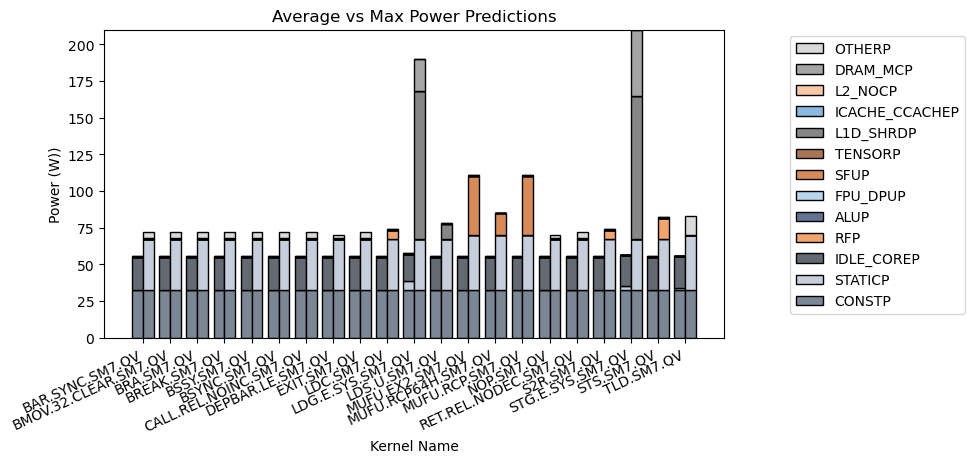

In [10]:
import numpy as np
import matplotlib.pyplot as plt

custom_colors = ["#D9D9D9","#A5A5A5","#F7C8A8","#8CB9E1","#868686","#A97655","#D68B58","#BAD5ED","#637492","#F2A46F","#646A71","#C5CEDA","#7C8796"]
custom_colors.reverse()

# Define the columns for stacking
stack_columns = ['CONSTP', 'STATICP', 'IDLE_COREP','RFP', 'ALUP', 'FPU_DPUP', 'SFUP', 'TENSORP', 'L1D_SHRDP', 'ICACHE_CCACHEP', 'L2_NOCP', 'DRAM_MCP', 'OTHERP']

# Set the x-axis labels
x_labels = avg_df.index.str.replace("100_k1","").str.replace("_",".")

# Set the values for each stacked column
stack_values = avg_df[stack_columns].values.T
x_axis = np.arange(len(stack_values[0]))
stack_values[0],x_axis
bar_width=0.4
bar_offset=0.2

# Plot the avg graph
plt.figure(figsize=(8, 4))
for i in range(0, len(stack_columns)):
    plt.bar(x_axis-bar_offset, 
            stack_values[i], width=bar_width, 
            bottom=stack_values[:i].sum(axis=0), 
            label=stack_columns[i], 
            color=custom_colors[i%len(custom_colors)],
           edgecolor='black')
    
max_stack_values = max_df[stack_columns].values.T
# Plot the max graph
for i in range(0, len(stack_columns)):
    plt.bar(x_axis+bar_offset, 
            max_stack_values[i], width=bar_width, 
            bottom=max_stack_values[:i].sum(axis=0), 
            color=custom_colors[i%len(custom_colors)],
           edgecolor='black')
test_i=1
# print(stack_columns[test_i],max_stack_values[test_i],max_stack_values[:test_i].sum(axis=0))
    
#Now plot the ground truth
# plt.bar(x_axis+bar_offset,df[ground_truth_energy_column],width=bar_width,label=ground_truth_energy_column,color='black')
# # Rotate the x-labels by 90 degrees
plt.xticks(x_axis,x_labels,rotation=25,ha='right')

# Add labels and title
plt.xlabel('Kernel Name')
plt.ylabel('Power (W))')
plt.title('Average vs Max Power Predictions')

# Add legend
# Reverse the order of handles and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

# Add legend with reversed order
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.4,1),markerscale=10)
# # Show the plot
plt.show()

In [11]:
##Let's try to calculate some energies
dynamic = False

# Step 1: Filter columns ending with 'P'
filtered_df = max_df[stack_columns]

if dynamic:
    # Optional Step: Commented out filter to drop 'CONSTP' and 'STATICP' columns
    filtered_df = filtered_df.drop(columns=['CONSTP', 'STATICP'], errors='ignore')

# Step 2: Sum the values across the filtered columns
calc_power = filtered_df.sum(axis=1)  # Sum across all rows and columns

#Note that 80 blocks with 32 threads per block
inst_count = 80*32 
# Step 3: Calculate energy in Joules
frequency = 1132e6 #This is the frequency that is being used by AccelWattch #1530e6  # 1530 MHz
frequency = 1530e6  # 1530 MHz
#################################################
# THIS ASSUMES WE HAVE ONLY ONE CYCLE PER PROCESS
#################################################
cycle_time = 1 / frequency  # Time for one cycle
energy_joules = calc_power * cycle_time / inst_count  # Energy in Joules

# Step 4: Convert energy to picoJoules
energy_picojoules = energy_joules * 1e12
energy_picojoules.index = energy_picojoules.index.str.replace(f'_{target_string}','').str.replace('_k1','')
# Step 5: Show results
for index, energy in energy_picojoules.items():
    print(f"{index} {energy:.2f}")
energy_picojoules

BAR_SYNC 18.35
BMOV_32_CLEAR 18.35
BRA 18.35
BREAK 18.35
BSSY 18.35
BSYNC 18.35
CALL_REL_NOINC 18.35
DEPBAR_LE 17.95
EXIT 18.35
LDC 18.86
LDG_E_SYS 48.58
LDS_U 19.88
MUFU.EX2 28.30
MUFU_RCP64H 21.75
MUFU_RCP 28.30
NOP 17.95
RET_REL_NODEC 18.35
S2R 18.86
STG_E_SYS 53.66
STS 20.98
TLD 21.23


BAR_SYNC          18.349239
BMOV_32_CLEAR     18.349239
BRA               18.349239
BREAK             18.349239
BSSY              18.349239
BSYNC             18.349239
CALL_REL_NOINC    18.349239
DEPBAR_LE         17.949004
EXIT              18.349239
LDC               18.857848
LDG_E_SYS         48.578533
LDS_U             19.880469
MUFU.EX2          28.298131
MUFU_RCP64H       21.754728
MUFU_RCP          28.298131
NOP               17.949004
RET_REL_NODEC     18.349239
S2R               18.857848
STG_E_SYS         53.658573
STS               20.976517
TLD               21.232159
dtype: float64

In [12]:
write = False
if write:
    energy_picojoules.index = energy_picojoules.index.str.replace("_", ".")
    energy_picojoules['MUFU.RCP64H'] = energy_picojoules['MUFU.RCP']
    if dynamic:
        energy_picojoules.to_csv('energy_per_opcode_otherbuckets_energy_dynamic_median.csv',header=False)
    else:
        energy_picojoules.to_csv('energy_per_opcode_otherbuckets_measured_energy_median.csv',header=False)
                                                    

In [13]:
test = "hello"
"ell" not in test

False